In [1]:
import pandas as pd
import datetime, warnings, scipy 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("flights.csv",low_memory=False)
#print('Dataframe dimensions:', df.shape)

In [3]:
#Type of attributes and Null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values,0,0,0,0,0,0,14721,0,0,0,...,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,...,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


In [4]:
#YEAR MONTH DAY ARE A TYPE INT SO CHANGING THEM TO DATETIME
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [5]:
#Function to convert HHMM into suitable format
def change(attr):
    if pd.isnull(attr):
        return np.nan
    else:
        if attr == 2400: 
            attr = 0
        attr = "{0:04d}".format(int(attr))
        changed = datetime.time(int(attr[0:2]), int(attr[2:4]))  #Slicing the attribute as the first two is hours and the last two is minutes
        return changed

In [6]:
# Function that combines a date and time to produce a datetime.datetime
def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [7]:
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    list1 = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            list1.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            list1.append(combine_date(cols))
        else:
            cols[1] = change(cols[1])
            list1.append(combine_date(cols))
    return pd.Series(list1)

In [8]:
#This piece of takes long time to execute so executing on a subset of dataset as we were planning to do month wise prediction we are taking dataset for month==1

df=df[df['MONTH']==1]

df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(change)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(change)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(change)

In [9]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [11]:
#We can see that the filling factor is quite high approximately 97 percent so we can drop the null values in the dataset
df=df.dropna()
#a=df['ARRIVAL_DELAY']
#indexes = [index for index,element in enumerate(a) if np.isnan(element)]
#print(indexes)

In [12]:
airline_name=pd.read_csv('airlines.csv')
abbr_companies = airline_name.set_index('IATA_CODE')['AIRLINE'].to_dict()
#airline_name

#Sort the airline based on punctuality
def stats(group):
    return {'min': group.min(), 'max': group.max(),'count': group.count(), 'mean': group.mean()}

stats_all = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(stats).unstack()
stats_all = stats_all.sort_values('count')
stats_all

,count,max,mean,min
AIRLINE,,,,
VX,4647.0,397.0,6.896277,-20.0
HA,6408.0,1003.0,1.311954,-26.0
F9,6735.0,696.0,17.910765,-32.0
NK,8632.0,557.0,13.073100,-28.0
AS,13151.0,444.0,3.072086,-47.0
B6,20482.0,500.0,9.988331,-27.0
MQ,27568.0,780.0,15.995865,-29.0
US,32478.0,638.0,5.175011,-26.0
UA,37363.0,886.0,13.885555,-40.0


Number of airports: 312


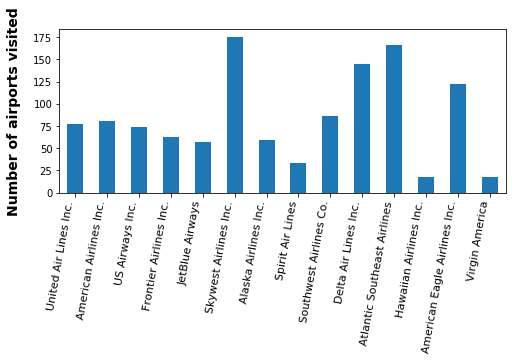

In [13]:
# Statistics about different airlines

print("Number of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
    
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()


In [14]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

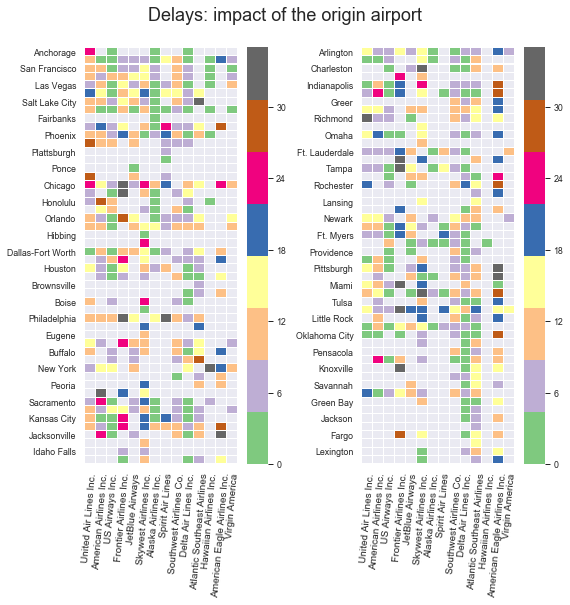

In [15]:
#How delay are affected by origin airport

airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

From the above heatmap we can see there is a lot of variation in the delay both between airports and different airlines so it is necessary to adopt a model that is specific to the company and the home airport. 

In [16]:
#Training has data for the first 3 weeks of january and testing data has data for last week of january
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train
print(df.shape)

(329515, 11)


In [17]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['depart']).apply(stats).unstack()
    test2.reset_index(inplace=True)
    test2.reset_index(inplace=True)
    test2['depart_min'] = test2['depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
    return test2

In [18]:
#Model 1 one airline all airports
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1831, 3)

In [19]:
# To make the predictions better we use one hot encoding to denote airports

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])

zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:10]
#merged_df['depart_min']

[(0, 'ABQ'),
 (1, 'ATL'),
 (2, 'AUS'),
 (3, 'BDL'),
 (4, 'BHM'),
 (5, 'BNA'),
 (6, 'BOS'),
 (7, 'BWI'),
 (8, 'CLE'),
 (9, 'CLT')]

In [20]:
#Contructing matrix to make predictions

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=200)

In [22]:
# Linear regression

lm = linear_model.LinearRegression()
model = lm.fit(X_train,Y_train)
predictions =model.predict(X_test)
print("RMSE =", np.sqrt(metrics.mean_squared_error(predictions, Y_test)))

RMSE = 8.25405039463443


To further decrease the rmse value we will next try to predict the values using polynomial regression.

In [23]:
#Polynomial Regression

poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
         
X_ = poly.fit_transform(X_test)
result =regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Root Mean squared error = ", np.sqrt(score))

Root Mean squared error =  21889.430977994973


The rmse value is value is quite high beacuse during the separation in train and test dataset data with no equivalent in the training set was put in test data so the model performs extrapolation, the extrapolated values will show have more importance. To avoid this we can use regularization method. Here we are using L2 regularization.

In [24]:
from sklearn.linear_model import Ridge

#To find the best value of alpha 
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        
        #regr = linear_model.LinearRegression()
        
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 68.124
n=1 alpha=0.2 , MSE = 66.316
n=1 alpha=0.4 , MSE = 65.576
n=1 alpha=0.6 , MSE = 65.33
n=1 alpha=0.8 , MSE = 65.328
n=1 alpha=1.0 , MSE = 65.448
n=1 alpha=1.2 , MSE = 65.63
n=1 alpha=1.4 , MSE = 65.841
n=1 alpha=1.6 , MSE = 66.062
n=1 alpha=1.8 , MSE = 66.282
n=2 alpha=0.0 , MSE = 107.57
n=2 alpha=0.2 , MSE = 69.71
n=2 alpha=0.4 , MSE = 68.708
n=2 alpha=0.6 , MSE = 68.141
n=2 alpha=0.8 , MSE = 67.753
n=2 alpha=1.0 , MSE = 67.475
n=2 alpha=1.2 , MSE = 67.274
n=2 alpha=1.4 , MSE = 67.131
n=2 alpha=1.6 , MSE = 67.031
n=2 alpha=1.8 , MSE = 66.965


In [25]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(np.sqrt(score))

7.53423184537599


In [26]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions =model.predict(X)
print("RMSE =", np.sqrt(metrics.mean_squared_error(predictions, Y)))

RMSE = 7.330966761228603


In [27]:
#Prediction for last week in january

carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

In [28]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [29]:
#Linear Regression
prediction=model.predict(X_test)
score = metrics.mean_squared_error(prediction, Y_test)
'RMSE = {:.2f}'.format(np.sqrt(score))

'RMSE = 7.81'

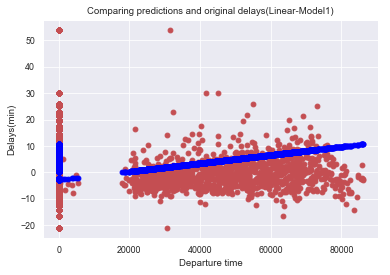

In [30]:
plt.plot(X_test,Y_test,'ro')
plt.plot(X_test,prediction,'ro',color='blue')
plt.xlabel("Departure time")
plt.ylabel("Delays(min)")
plt.title("Comparing predictions and original delays(Linear-Model1)")
plt.show()

In [31]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'RMSE = {:.2f}'.format(np.sqrt(score))

'RMSE = 7.61'

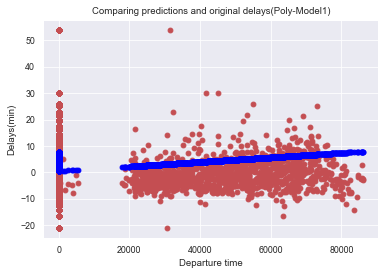

In [32]:
plt.plot(X_,Y_test,'ro',label='Original')
plt.plot(X_test,result,'ro',color='blue')
plt.xlabel("Departure time")
plt.ylabel("Delays(min)")
plt.title("Comparing predictions and original delays(Poly-Model1)")
plt.show()

In [33]:
#Model 2 Considering destinations

def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    df2['depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['depart'] = df2['depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
    df2['arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
    df3 = df2.groupby(['depart', 'arrivee','ORIGIN_AIRPORT'],as_index = False).mean()
    return df3

In [34]:
df3 = create_df(df, carrier)    
df3

,depart,arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000
5,1800,9180,CLT,0.000000,6.000000
6,1800,20340,SFO,4.117647,2.823529
7,1800,20400,RNO,-0.750000,3.750000
8,1800,20700,SFO,10.000000,3.600000
9,1800,22800,SEA,15.333333,3.000000


In [35]:
#Doing one hot encoding

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])

zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

b = np.array(df3[['depart', 'arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=200)

In [37]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 83.297
n=1 alpha=0.2 , MSE = 81.994
n=1 alpha=0.4 , MSE = 81.581
n=1 alpha=0.6 , MSE = 81.619
n=1 alpha=0.8 , MSE = 81.891
n=1 alpha=1.0 , MSE = 82.285
n=1 alpha=1.2 , MSE = 82.737
n=1 alpha=1.4 , MSE = 83.214
n=1 alpha=1.6 , MSE = 83.694
n=1 alpha=1.8 , MSE = 84.166
n=2 alpha=0.0 , MSE = 5952.6
n=2 alpha=0.2 , MSE = 82.807
n=2 alpha=0.4 , MSE = 82.458
n=2 alpha=0.6 , MSE = 82.228
n=2 alpha=0.8 , MSE = 82.07
n=2 alpha=1.0 , MSE = 81.968
n=2 alpha=1.2 , MSE = 81.912
n=2 alpha=1.4 , MSE = 81.894
n=2 alpha=1.6 , MSE = 81.908
n=2 alpha=1.8 , MSE = 81.947


In [38]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result=ridgereg.predict(X_)
score=metrics.mean_squared_error(result,Y)
print(np.sqrt(score))

9.463102965064392


In [39]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions =model.predict(X)
score=metrics.mean_squared_error(predictions,Y)
print(np.sqrt(score))

8.772306581300505


In [40]:
#Predicting

df3 = create_df(df_test, carrier)   

label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['depart', 'arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [41]:
#Polynomial Regression
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('RMSE = {}'.format(round(np.sqrt(score), 2)))

RMSE = 8.63


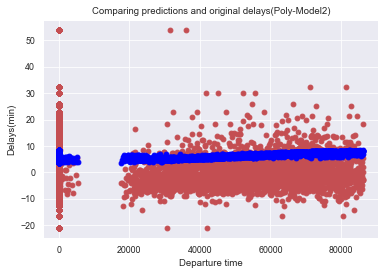

In [42]:
plt.plot(X_,Y_test,'ro',label='Original')
plt.plot(X_test,result,'ro',color='blue')
plt.xlabel("Departure time")
plt.ylabel("Delays(min)")
plt.title("Comparing predictions and original delays(Poly-Model2)")
plt.show()

In [43]:
#Linear Regression
predictions =model.predict(X_test)
print("RMSE =", np.sqrt(metrics.mean_squared_error(predictions, Y_test)),"min")

RMSE = 7.951396772440874 min


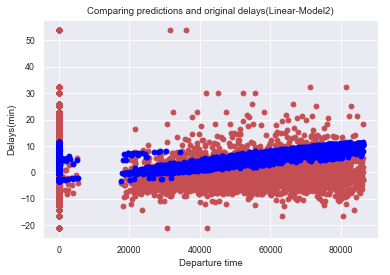

In [44]:
plt.plot(X_test,Y_test,'ro',label='Original')
plt.plot(X_test,predictions,'ro',color='blue')
plt.xlabel("Departure time")
plt.ylabel("Delays(min)")
plt.title("Comparing predictions and original delays(Linear-Model2)")
plt.show()